# PCA-like convolutional autoencoder

In [1]:
import keras
import keras.backend as K
import matplotlib.pyplot as plt; plt.gray()
%matplotlib inline
import numpy as np; np.random.seed(1)
import tensorflow as tf
from skimage import draw
import dataset

In [2]:
expl_idx = 0
vmin, vmax = -128, 128
nrows, ncols = 64, 64
nsamples = 10_000
ncomponents = 3
batch_size = 32  # PCACAE needs small batch sizes, otherwise training fluctuates heavily..

### 1. Generate data

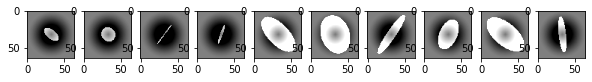

In [3]:
data = dataset.construct(nsamples, nrows, ncols, "ellipse")
X = data - data.mean(axis=0) # center data: same input data as PCA.
X = K.reshape(X, (-1, nrows, ncols, 1))

fig, axs = plt.subplots(1, 10, figsize=(10,1))
for (i, ax) in enumerate(axs):
    ax.imshow(tf.reshape(X[i], (nrows, ncols)), vmin=vmin, vmax=vmax)

### 2. Create model
* Convolutional model has **much** less parameters and converges faster, i.e. reaches lower loss in fewer epochs.

In [4]:
class CovReg(keras.regularizers.Regularizer):
    def __init__(self, w=1.0):
        self.w = w
    def __call__(self, a):
        acc  = K.sum( K.square(a[-1,:] * a[:-1,:]))
        loss = acc / (a.shape[-1]**2)
        return self.w * loss

def build_encoder(input_layer):
    return keras.Sequential([
        input_layer,
        keras.layers.Conv2D(filters=8, kernel_size=4, strides=2, padding='same', activation='sigmoid', use_bias=False),
        keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='same', activation='sigmoid', use_bias=False),
        keras.layers.Flatten(),
        keras.layers.Dense(units=1, activation='linear', use_bias=False),
        keras.layers.BatchNormalization(center=False, scale=False)
    ])

def build_decoder(n):
    return keras.Sequential([
        keras.layers.Input(shape=(n,)),
        keras.layers.Dense(units=nrows//4*ncols//4*16, activation='sigmoid', use_bias=False), # add units to avoid bottleneck forming here.
        keras.layers.Reshape(target_shape=(nrows//4,ncols//4,16)),      # .. reshape those units into channel dimension.
        keras.layers.Conv2DTranspose(filters=8, kernel_size=4, strides=2, padding='same', activation='sigmoid', use_bias=False),
        keras.layers.Conv2DTranspose(filters=1, kernel_size=4, strides=2, padding='same', activation='linear', use_bias=False),
    ])

### 3. Train model

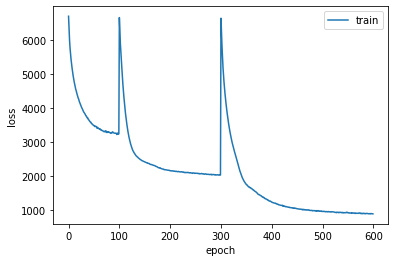

In [5]:
input_layer = keras.layers.Input(shape=(nrows,ncols,1))
encoders = []

epochs = [100, 200, 300] # schedule epochs such that learning saturates.

for i in range(ncomponents):
    encoders.append( build_encoder(input_layer) ) # same input layer for all encoders
    decoder = build_decoder(n=i+1)  # increase input size of decoder w/ each training
    
    for e in encoders[:i]: 
        e.trainable = False # only train i-th latent neuron
    
    if i >= 1:
        encoded = keras.layers.concatenate([e(input_layer) for e in encoders], 
                                           activity_regularizer=CovReg())
    else:
        encoded = encoders[0](input_layer)  # concatenate needs at least two layers.
    
    pcacae = keras.models.Model(input_layer, decoder(encoded))
    pcacae.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-3))
    
    if i >= 1:
        pcacae.fit(X, X, epochs=epochs[i], batch_size=batch_size, verbose=0, callbacks=[history])
    else:
        history = pcacae.fit(X, X, epochs=epochs[i], batch_size=batch_size, verbose=0)

plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

### 4. Transform into and from latent space

Z_mean = -0.017332101240754128, Z_var = 1.0317047834396362


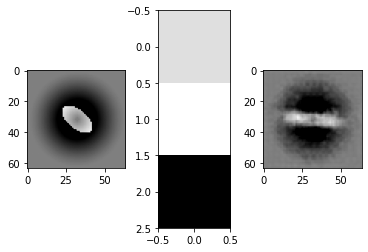

In [6]:
# lim = 100
Z = np.array([e.predict(X) for e in encoders], dtype='float32').reshape(nsamples, ncomponents) # only subset; otherwise too large for my GPU.
print(f"Z_mean = {Z.mean()}, Z_var = {Z.var()}")
X_pred = decoder(Z)

fig, ax = plt.subplots(ncols=3, nrows=1)
ax[0].imshow(tf.reshape(X[expl_idx],(nrows, ncols)), vmin=vmin, vmax=vmax)
ax[1].imshow(tf.reshape(Z[expl_idx], (-1, 1)))
ax[2].imshow(tf.reshape(X_pred[expl_idx], (nrows, ncols)), vmin=vmin, vmax=vmax)

### 5. Interpolation in latent space

In [7]:
from ipywidgets import interactive
import ipywidgets as widgets

def f(**kwargs):
    z = np.array(list(kwargs.values()), dtype='float32')
    x_pred = decoder(z.reshape(1,-1))
    plt.figure(2)
    plt.imshow(tf.reshape(x_pred,(nrows, ncols)), vmin=vmin, vmax=vmax)

scores = Z[expl_idx]
sliders = {f"PC{i+1}": widgets.FloatSlider(min=tf.reduce_min(z),max=tf.reduce_max(z),value=score) 
           for (i,score), z in zip(enumerate(scores), tf.transpose(Z))}

interactive(f, **sliders)
ix_plot = interactive(f, **sliders)
output = ix_plot.children[-1]
output.layout.height = '250px'
ix_plot

interactive(children=(FloatSlider(value=-0.7347575426101685, description='PC1', max=3.0990850925445557, min=-2…

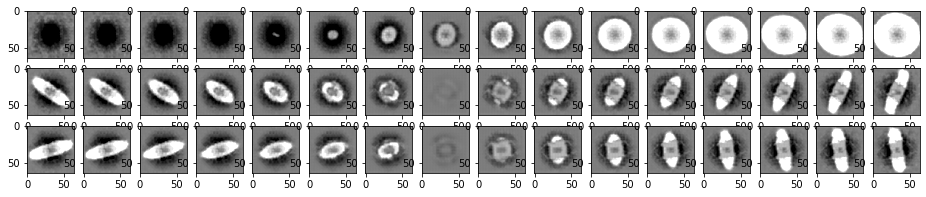

In [8]:
steps = 16
z_vars = [np.linspace(np.min(ax), np.max(ax), steps) for ax in tf.transpose(Z)] # interpolation range
fig, axs = plt.subplots(ncols=steps, nrows=ncomponents, figsize=(steps, ncomponents))

for i in range(ncomponents):
    for j in range(steps):
        z = np.zeros_like(Z[expl_idx])
        z[i] = z_vars[i][j]
        x_pred = decoder.predict(z.reshape(1, -1))
        ax = list(axs.flat)[j+i*j] if ncomponents==1 else axs[i, j]
        ax.imshow(tf.reshape(x_pred, (nrows, ncols)), vmin=vmin, vmax=vmax)

### 6. Properties of CAE

Cov of latent activations:
 tf.Tensor(
[[ 1.0243455  -0.00778817  0.02036254]
 [-0.00778817  1.0293878  -0.00300852]
 [ 0.02036254 -0.00300852  1.0410771 ]], shape=(3, 3), dtype=float32)
===> Latent components are heavily correlated.


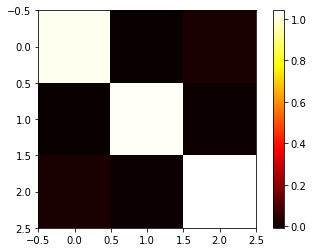

In [9]:
# pcs = encoder.weights[0]
# I = (tf.transpose(pcs) @ pcs)
# print("Dot product of all encoder weights:\n", np.round(I, 5))
# print("===> Weights are neither orthogonal nor unit norm.")

fig, ax = plt.subplots()
Z = tf.subtract(Z, tf.reduce_mean(Z, axis=0))
Z_cov = (tf.transpose(Z) @ Z) / (nsamples-1)
print("Cov of latent activations:\n", Z_cov)
plt.imshow(Z_cov, cmap='hot')
plt.colorbar();
print("===> Latent components are heavily correlated.")

### 7. Calculate MSE

In [10]:
X_pred = pcacae.predict(X)
print("MSE: ", np.square(np.subtract(X, X_pred)).mean())

MSE:  813.9884
